In [1]:
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import shapiro
import sys
sys.modules.pop("mlmarker", None)

import mlmarker
print(mlmarker.__file__)
import mlmarker.model as MLMarker
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import pyteomics
from pyteomics import auxiliary as aux
pd.options.mode.chained_assignment = None

import tqdm
sys.path.append('/home/compomics/git/Projects/MLMarker_paper')
from MLMarker_reprocessing_quant import *

import umap
import sys
sys.setrecursionlimit(10000)
plt.figure(figsize=(20,20))

import dash_bio

/home/compomics/git/MLMarker/mlmarker/__init__.py


<Figure size 2000x2000 with 0 Axes>

In [33]:
def ionbot_first_to_prot_quant(df, lengths):
    """Only search in the rows : q-value <= 0.01, database = T, proteins != CONTAMINANT and '|'  
    Return a DataFrame with columns 'proteins', 'modifications', 'count', 'Length', 'SAF', 'NSAF'"""
    logging.info("Starting ionbot_first_to_prot_quant")
    if 'proteins' not in df.columns:
        logging.error("Column 'proteins' is missing in the input DataFrame. Terminating function.")
        return pd.DataFrame()

    df = df[['proteins', 'modifications', 'database', 'q-value']]
    df = df[(df['database']=='T') & (df['q-value']<=0.01)]
    df = df[~df['proteins'].apply(lambda x: '|' in x or 'CONTAMINANT' in x)]
    df["uniprot_id"] = df['proteins'].apply(lambda uniprot: re.search(r'\)\)\(\((.*?)\)\)', uniprot).group(1) 
                                        if re.search(r'\)\)\(\((.*?)\)\)', uniprot) else None) # Found the uniprot id with a ))((.*)) pattern
                                        
    df = df.value_counts().to_frame().reset_index()
    df = df.merge(lengths, left_on='uniprot_id', right_on='Entry')
    df = df[df['Length'] != np.nan]
    df['count'] = df['count'].astype(float)
    df['Length'] = df['Length'].astype(float)
    df['SAF'] = df['count']/df['Length']
    total_SAF = df['SAF'].sum()
    df['NSAF'] = df['SAF']/total_SAF
    return df


In [2]:
oxidations_list = pd.read_csv('oxidations_robbe.tsv', sep='\t')
oxidations_unimods = oxidations_list['Unimod #'].tolist()

In [3]:
poor_notbrain = ['poor_responder_5_2.mgf.gzip', 'poor_responder_6_1.mgf.gzip', 'poor_responder_4_1.mgf.gzip', 'poor_responder_6_2.mgf.gzip', 'poor_responder_5_1.mgf.gzip', 'poor_responder_4_2.mgf.gzip']
good_notbrain = ['good_responder_4_1.mgf.gzip', 'good_responder_2_1.mgf.gzip', 'good_responder_2_2.mgf.gzip', 'good_responder_1_1.mgf.gzip', 'good_responder_1_2.mgf.gzip', 'good_responder_4_2.mgf.gzip']
poor_brain = ['poor_responder_12_1.mgf.gzip', 'poor_responder_8_2.mgf.gzip', 'poor_responder_7_2.mgf.gzip', 'poor_responder_13_1.mgf.gzip', 'poor_responder_11_2.mgf.gzip', 'poor_responder_1_2.mgf.gzip', 'poor_responder_9_2.mgf.gzip', 'poor_responder_1_1.mgf.gzip', 'poor_responder_11_1.mgf.gzip', 'poor_responder_3_1.mgf.gzip', 'poor_responder_2_2.mgf.gzip', 'poor_responder_2_1.mgf.gzip', 'poor_responder_10_1.mgf.gzip', 'poor_responder_3_2.mgf.gzip', 'poor_responder_13_2.mgf.gzip', 'poor_responder_12_2.mgf.gzip', 'poor_responder_8_1.mgf.gzip', 'poor_responder_7_1.mgf.gzip', 'poor_responder_9_1.mgf.gzip', 'poor_responder_10_2.mgf.gzip']
good_brain = ['good_responder_3_2.mgf.gzip', 'good_responder_5_1.mgf.gzip', 'good_responder_3_1.mgf.gzip', 'good_responder_5_2.mgf.gzip']
all_samples = poor_notbrain + good_notbrain + poor_brain + good_brain

In [35]:
all_modifications = pd.DataFrame()
for f in tqdm.tqdm(all_samples):
    x = pd.read_csv(f"/home/compomics/conode53_pride/PRIDE_DATA/PXD007592/IONBOT_v0.11.3/{f}/ionbot.first.csv")
    l = pd.read_csv('/home/compomics/git/Projects/MLMarker_paper/uniprot_reviewed_lengths.tsv', sep='\t')
    df = ionbot_first_to_prot_quant(df=x, lengths=l)
    df['filename'] = f
    all_modifications = pd.concat([all_modifications, df])

100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


In [36]:
#all_modifications contains unimod numbers between squared brackets [] in the 'modifications' column
#keep the rows where that number occurs in the list of 
all_modifications['filetype'] = all_modifications['filename'].apply(lambda x: 'poor_notbrain' if x in poor_notbrain else 'good_notbrain' if x in good_notbrain else 'poor_brain' if x in poor_brain else 'good_brain')

def extract_unimods(modifications):
    return [int(num) for num in re.findall(r'\[(\d+)\]', modifications)]

# Filter rows where any unimod number is in the oxidations_unimods list
filtered_modifications = all_modifications[
    all_modifications['modifications'].apply(lambda x: any(num in oxidations_unimods for num in extract_unimods(x)))
]

print(filtered_modifications)

                              proteins  \
0      ALBU_HUMAN((570-582))((P02768))   
6       HSP7C_HUMAN((57-72))((P11142))   
14    STAT1_HUMAN((389-406))((P42224))   
20    IGLL1_HUMAN((112-131))((P15814))   
34      IGKC_HUMAN((84-101))((P01834))   
...                                ...   
8223    G3P_HUMAN((310-324))((P04406))   
8224    G3P_HUMAN((310-324))((P04406))   
8226    G3P_HUMAN((235-249))((P04406))   
8227    G3P_HUMAN((235-249))((P04406))   
8230   ZZZ3_HUMAN((502-530))((Q8IYH5))   

                                          modifications database   q-value  \
0                                    3|[35]Oxidation[M]        T  0.000072   
6                                    5|[35]Oxidation[M]        T  0.000072   
14               4|[35]Oxidation[M]||9|[7]Deamidated[N]        T  0.000072   
20                         3|[360]Pro->Pyrrolidinone[P]        T  0.000072   
34                                4|[6]Carboxymethyl[C]        T  0.000072   
...                        

In [62]:
filtered_modifications2 = filtered_modifications[~filtered_modifications['modifications'].str.contains(r'.*\[35\]Oxidation\[M\]$')]


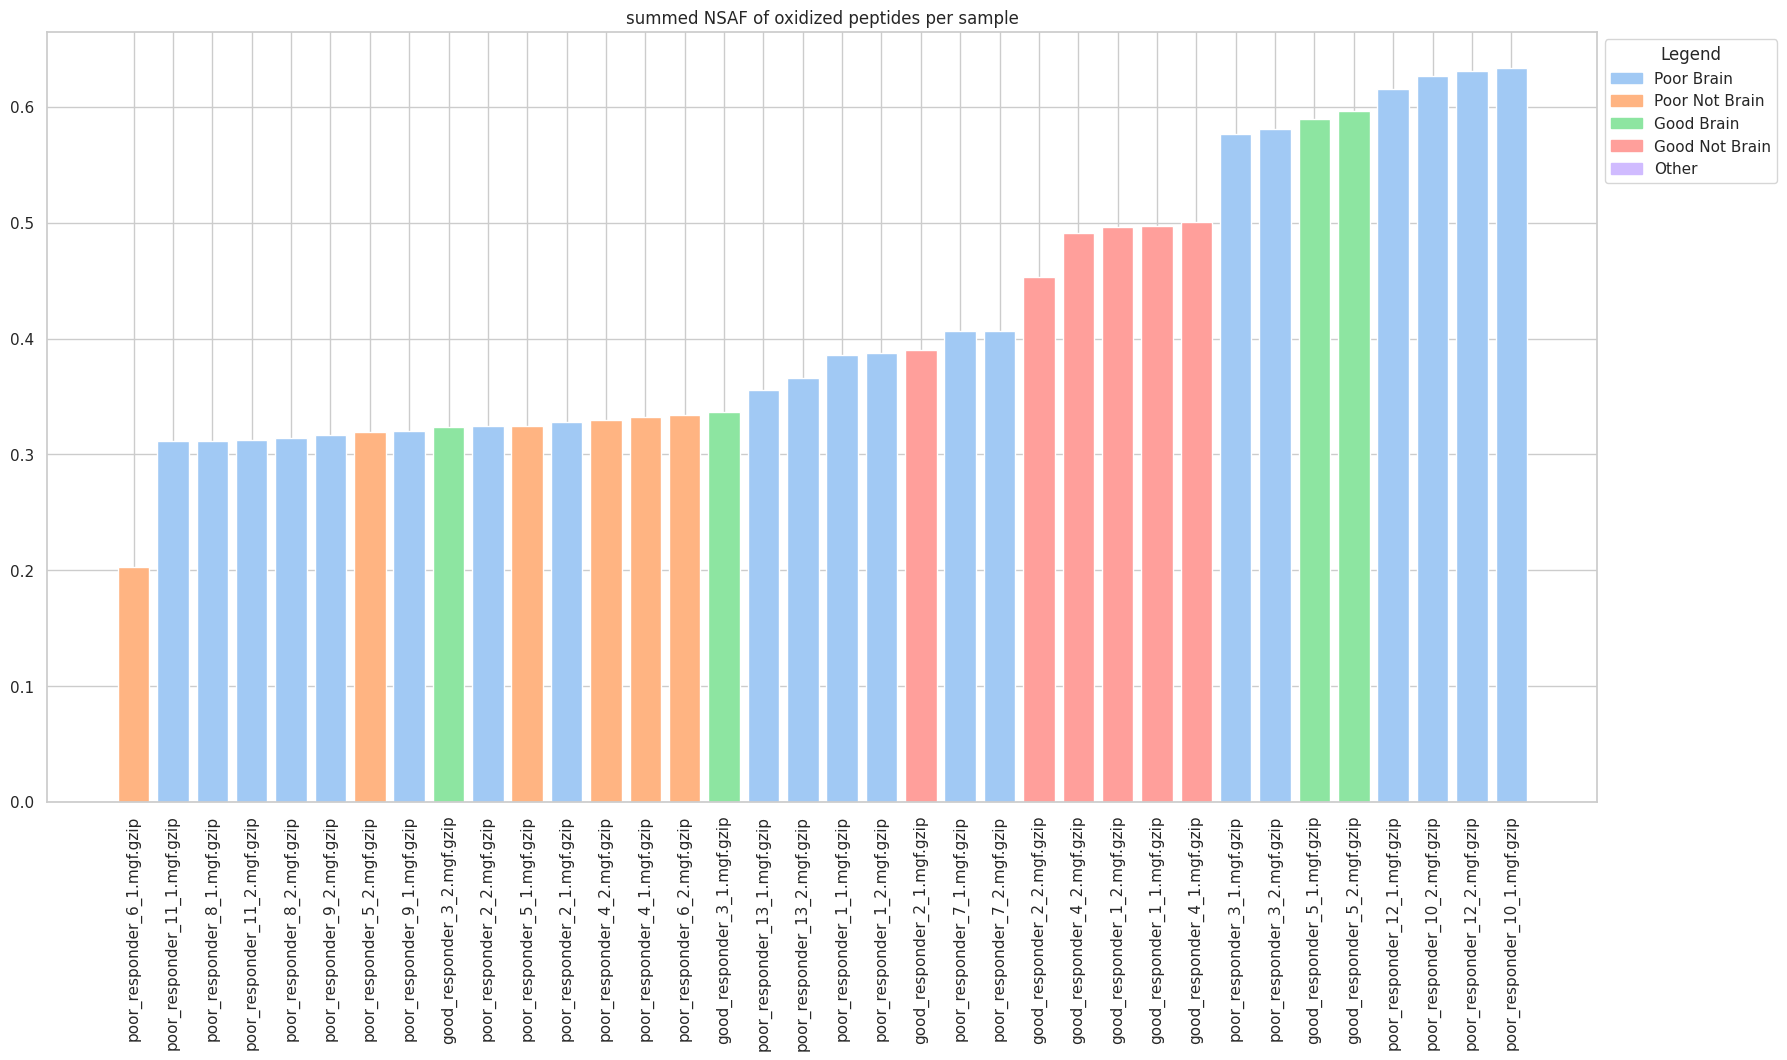

In [63]:
import seaborn as sns
plt.figure(figsize=(20,10))
grouped_nsafs = filtered_modifications2.groupby(['filename'])['NSAF'].sum().reset_index().sort_values(by='NSAF')

# Define the colors for different categories
palette = sns.color_palette("pastel")
colors = []
for filename in grouped_nsafs['filename']:
    if filename in poor_brain:
        colors.append(palette[0])
    elif filename in poor_notbrain:
        colors.append(palette[1])
    elif filename in good_brain:
        colors.append(palette[2])
    elif filename in good_notbrain:
        colors.append(palette[3])


plt.bar(grouped_nsafs['filename'], grouped_nsafs['NSAF'], color=colors)
plt.xticks(rotation=90)

# Create legend patches
red_patch = mpatches.Patch(color=palette[0], label='Poor Brain')
orange_patch = mpatches.Patch(color=palette[1], label='Poor Not Brain')
blue_patch = mpatches.Patch(color=palette[2], label='Good Brain')
green_patch = mpatches.Patch(color=palette[3], label='Good Not Brain')


# Add legend
plt.legend(handles=[red_patch, orange_patch, blue_patch, green_patch, gray_patch], loc='upper left', bbox_to_anchor=(1, 1), title='Legend')
plt.title('summed NSAF of oxidized peptides per sample')
plt.show()


In [77]:
grouped_nsafs['filetype'] = grouped_nsafs['filename'].apply(lambda x: 'poor_notbrain' if x in poor_notbrain else 'good_notbrain' if x in good_notbrain else 'poor_brain' if x in poor_brain else 'good_brain')
grouped_nsafs['mlmarker'] = grouped_nsafs['filetype'].apply(lambda x: 'notbrain' if 'notbrain' in x else 'brain')
grouped_nsafs['response'] = grouped_nsafs['filename'].apply(lambda x: 'poor' if 'poor' in x else 'good')

<Axes: xlabel='response', ylabel='NSAF'>

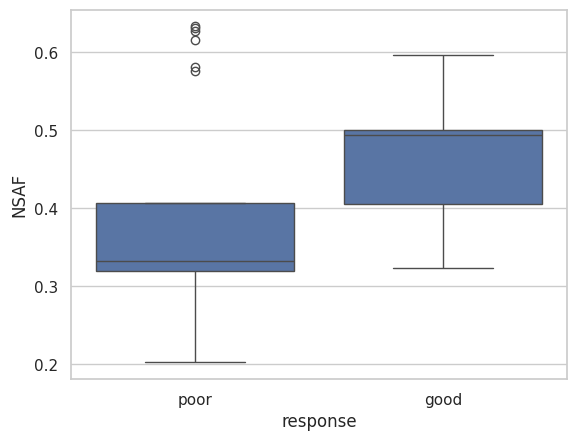

In [75]:
sns.boxplot(grouped_nsafs, x='response', y='NSAF')

<Axes: xlabel='mlmarker', ylabel='NSAF'>

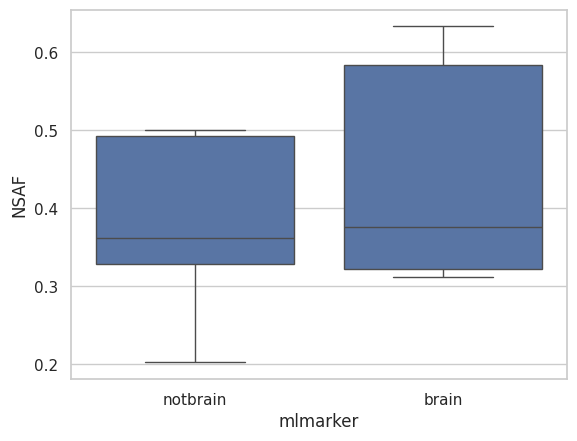

In [78]:
sns.boxplot(grouped_nsafs, x='mlmarker', y='NSAF')

<Axes: xlabel='filetype', ylabel='NSAF'>

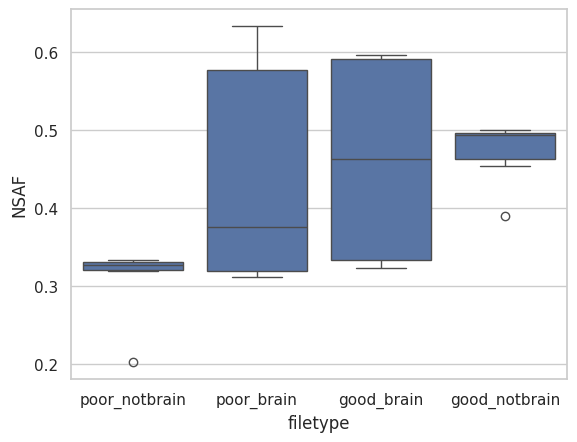

In [79]:
sns.boxplot(grouped_nsafs, x='filetype', y='NSAF')